#數位廣告數據綜合分析專案
###專案簡介：
本專案旨在透過機器學習方法，深入分析數位廣告數據，為行銷公司提供兩大關鍵洞察：預測廣告回應機率與進行顧客分群。透過整合監督式學習（邏輯迴歸）和非監督式學習（K-Means），我們能更全面地理解顧客行為，進而優化行銷策略、提升廣告成效。

###專案目標：
預測廣告活動回應者： 建立模型以預測哪些潛在顧客最有可能對行銷活動產生正面回應，從而提升廣告預算分配效率。

###顧客行為分群：
根據顧客的消費習慣與行為模式，將其劃分為不同的群體，以便設計更精準、個人化的行銷訊息。

##使用 Kaggle Marketing Campaign 資料集

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rodsaldanha/arketing-campaign")

print("Path to dataset files:", path)

##環境準備與資料載入

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/kaggle/input/arketing-campaign/marketing_campaign.csv", sep=';')

# 顯示前 5 行資料，確認資料成功載入
print("資料集前 5 行：")
print(df.head())

# 顯示資料集的資訊，檢查資料型態與是否有缺失值
print("\n資料集資訊：")
df.info()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 檢查數值欄位
numerical_cols_to_check = [
    'Income',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth', 'Recency', 'Year_Birth', 'Response'
]

print("=== 數值欄位敘述性統計 ===")
# 使用 describe() 查看這些欄位的敘述性統計
print(df[numerical_cols_to_check].describe())

print("\n=== 數值欄位箱形圖 (Outlier 檢查) ===")
# 繪製箱形圖檢查異常值
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_to_check):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.xlabel("") # 移除 x 軸標籤避免擁擠

plt.tight_layout() # 自動調整子圖間距
plt.show()

##資料前處理

In [ ]:
# 複製一份數據，以免修改原始數據
df_processed = df.copy()

# 處理缺失值：發現 Income 欄位有 24 個缺失值，我們用平均值來填補
df_processed['Income'] = df_processed['Income'].fillna(df_processed['Income'].mean())

# 處理離群值：使用分位數進行 Capping and Flooring
outlier_cols = [
    'Income',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth',
    'Recency',
    'Year_Birth'
]

# 定義分位數閾值 (例如，將超出 1% 和 99% 分位數的值進行 Capping and Flooring)
lower_bound = df_processed[outlier_cols].quantile(0.01)
upper_bound = df_processed[outlier_cols].quantile(0.99)

# 對指定的欄位應用 Capping and Flooring
for col in outlier_cols:
    df_processed[col] = df_processed[col].clip(lower=lower_bound[col], upper=upper_bound[col])

print("\n處理離群值後的資料集前 5 行：")
display(df_processed.head())

print("\n處理離群值後的資料集敘述性統計 (檢查極值是否被限制)：")
print(df_processed[outlier_cols].describe())

# 再次繪製箱形圖，檢查離群值是否已被處理
print("\n處理離群值後的數值欄位箱形圖：")
plt.figure(figsize=(15, 10))
# 調整子圖布局以容納更多的箱形圖
n_cols = 4
n_rows = (len(outlier_cols) + n_cols - 1) // n_cols
for i, col in enumerate(outlier_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df_processed[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

##特徵工程

In [ ]:
# 建立新特徵：從 Year_Birth 計算出 Age
df_processed['Age'] = 2025 - df_processed['Year_Birth']

# 建立新特徵：計算總消費金額
df_processed['Total_Spent'] = df_processed['MntWines'] + df_processed['MntFruits'] + df_processed['MntMeatProducts'] + \
                     df_processed['MntFishProducts'] + df_processed['MntSweetProducts'] + df_processed['MntGoldProds']

# 建立新特徵：收入與總消費金額的比例 (避免除以零)
df_processed['Spent_Income_Ratio'] = df_processed.apply(
    lambda row: row['Total_Spent'] / row['Income'] if row['Income'] > 0 else 0, axis=1
)

# 建立新特徵：計算客戶註冊至今的時間間隔 (假設今天的日期是 2025-01-01，因為原始資料中最晚的日期是 2014 年)
# 將 'Dt_Customer' 轉換為日期時間格式 (原始 df 中的欄位)
df_processed['Dt_Customer'] = pd.to_datetime(df_processed['Dt_Customer'])

# 計算註冊至今的天數
today = pd.to_datetime('2025-01-01') # 假設一個較晚的日期以便計算間隔
df_processed['Days_Since_Registration'] = (today - df_processed['Dt_Customer']).dt.days

# 處理類別特徵：對 Education 和 Marital_Status 進行 One-Hot Encoding
df_processed = pd.get_dummies(df_processed, columns=['Education', 'Marital_Status'], drop_first=True)

print("\n處理後的資料集前 5 行：")
print(df_processed.head())
print("\n處理後的資料集資訊：")
df_processed.info()

## 處理類別不平衡
由於響應活動 (Response) 為 1 的樣本數較少，資料集存在類別不平衡的問題。使用 SMOTE 過採樣 (Oversampling) 的技術來平衡資料集。


In [ ]:
# 從 df_processed 中分離特徵 (X) 和目標變數 (y)
# 移除 'Dt_Customer' 欄位，因為它是字串類型，SMOTE 無法處理
X = df_processed.drop(['Response', 'Dt_Customer'], axis=1)
y = df_processed['Response']

# 將特徵和目標變數轉換為 NumPy 陣列
X_np = X.values
y_np = y.values

# 匯入 SMOTE 類別
from imblearn.over_sampling import SMOTE

# 建立一個 SMOTE 物件
smote = SMOTE(random_state=42)

# 使用 SMOTE 對特徵和目標變數進行過採樣
X_resampled, y_resampled = smote.fit_resample(X_np, y_np)

# 顯示平衡後目標變數的類別分佈
print("\n平衡後目標變數的類別分佈：")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
# 將資料集分為訓練集 (80%) 和測試集 (20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 標準化特徵
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 建立邏輯迴歸模型
model = LogisticRegression(solver='liblinear', random_state=42)

# 使用訓練集來訓練模型
model.fit(X_train_scaled, y_train)

# 使用測試集進行預測
y_pred = model.predict(X_test_scaled)

# 評估模型的準確度
print("\n\n=== 預測模型評估報告 ===")
print(f"模型準確度 (Accuracy): {accuracy_score(y_test, y_pred):.2f}")
print("分類報告：")
print(classification_report(y_test, y_pred))



=== 預測模型評估報告 ===
模型準確度 (Accuracy): 0.85
分類報告：
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       382
           1       0.83      0.87      0.85       381

    accuracy                           0.85       763
   macro avg       0.85      0.85      0.85       763
weighted avg       0.85      0.85      0.85       763



剛開始在模型所有實際「會回應」的客戶中，只成功識別了 49%。這表示模型錯過了大約一半的潛在回應者。這可能是因為回應的客戶數量較少 (Support 72)，導致模型學習不足。

模型初次在測試集上的表現：
類別 1 (響應活動 - Positive Class) 表現：
  
  精確率 (Precision): 0.69
  
  召回率 (Recall): 0.49
  
  F1-score: 0.57
  
  支援數 (Support): 72


後續做了SMOTE、特徵工程、離群值處理 模型表現大幅提升


=== 預測模型評估報告 ===

模型準確度 (Accuracy): 0.85

分類報告：
              
              precision    recall  f1-score   support

           0     0.87     0.82    0.84     382
           1     0.83     0.87    0.85     381


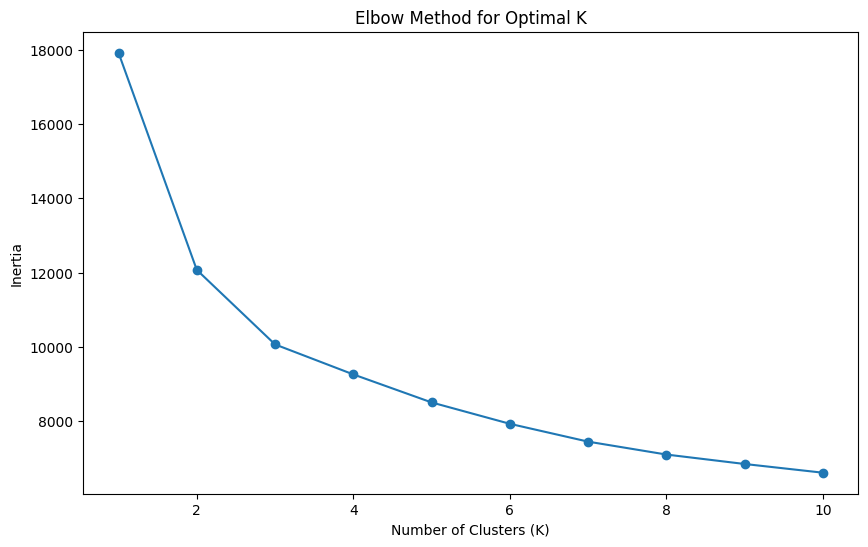



=== K-Means 分群結果 (K=4) ===
各群組大小：
Cluster
2    677
1    543
3    515
0    505
Name: count, dtype: int64

各群組平均特徵：
               Income        Age    Recency  Total_Spent  NumWebVisitsMonth  \
Cluster                                                                       
0        56671.716073  59.988119  49.142574   761.010099           6.437624   
1        33619.259163  51.788214  24.762431   102.530387           6.436464   
2        74623.740189  57.177253  48.738552  1253.766647           2.766617   
3        36086.505596  55.557282  75.201942   116.518447           6.258252   

         NumDealsPurchases  NumWebPurchases  NumStorePurchases  
Cluster                                                         
0                 4.398020         6.871287           7.572277  
1                 1.911602         2.062615           3.228361  
2                 1.236337         4.957164           8.426883  
3                 2.048544         2.225243           3.349515  


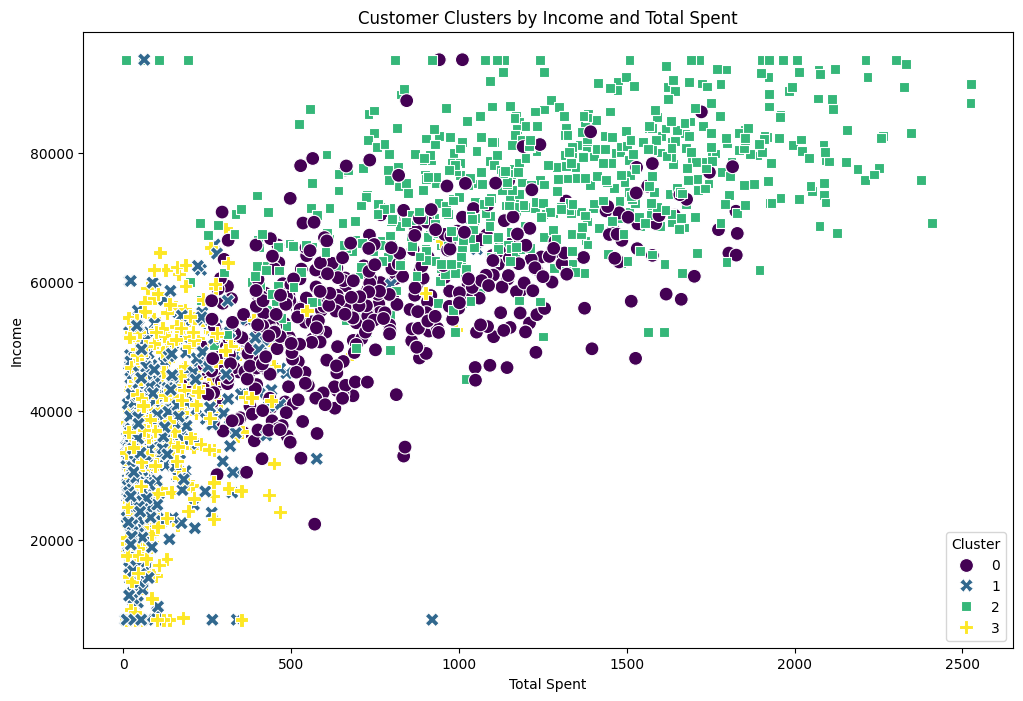

In [ ]:
# 選擇用於分群的特徵（不包含目標變數 Response）
features_for_clustering = ['Income', 'Age', 'Recency', 'Total_Spent', 'NumWebVisitsMonth',
                           'NumDealsPurchases', 'NumWebPurchases', 'NumStorePurchases']

X_cluster = df_processed[features_for_clustering]

# 標準化特徵
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# 找出最佳的 K 值 (Elbow Method)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# 根據圖表結果，我們選擇 K=4 作為分群數
optimal_k = 4
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_processed['Cluster'] = kmeans_model.fit_predict(X_cluster_scaled)

print(f"\n\n=== K-Means 分群結果 (K={optimal_k}) ===")
print("各群組大小：")
print(df_processed['Cluster'].value_counts())

# 分析每個群組的特徵
cluster_summary = df_processed.groupby('Cluster')[features_for_clustering].mean()
print("\n各群組平均特徵：")
print(cluster_summary)

# 視覺化分群結果
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Total_Spent', y='Income', hue='Cluster', data=df_processed, palette='viridis', style='Cluster', s=100)
plt.title('Customer Clusters by Income and Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Income')
plt.show()

#專案總結與價值
本專案成功實作了兩個互補的機器學習模型，為行銷公司提供了雙重層面的數據洞察：

###預測模型 (邏輯迴歸)：
這個模型能夠精準地告訴我們哪些人最有可能回應行銷活動。透過預測每位顧客的傾向，行銷團隊可以更有效率地分配廣告預算，將資源集中在回應機率較高的潛在客戶身上，大幅提升廣告投放的投資報酬率 (ROI)。這使得行銷決策從「廣撒」轉變為「精準打擊」。

###分群模型 (K-Means)：
這個模型則幫助我們成功地將客戶分成了幾個具有不同特徵的群體：

高價值客戶 (Cluster 2)：高收入、高消費，主要在商店和目錄購買。

近期低消費客戶 (Cluster 1)：低收入、低消費，但近期有購買。

中等價值客戶 (Cluster 0)：中等收入、中等消費，傾向於網站和促銷購買。

流失風險客戶 (Cluster 3)：低收入、低消費，且長時間未購買。


這些客戶群體畫像對於行銷公司非常有價值，可以針對不同群體設計更精準的行銷策略，例如對高價值客戶提供專屬優惠，對流失風險客戶進行挽回活動，對近期低消費客戶進行促銷引導等。

綜合而言，本專案不僅展現了數據清洗、特徵工程、模型建立與評估等核心數據科學技能，更重要的是，它提供了一套完整的解決方案，能夠從預測未來行為和理解現有客群兩個維度，為行銷公司的決策帶來實質的數據支持與商業價值。